# 第3章 word2vec
この章でも単語の分散表現を学ぶ

## 3.1 推論ベースの手法とニューラルネットワーク

### 3.1.1 カウントベースの手法の問題点
SVDの計算量がオーダー$O(n^3)$なので，語彙数が100万とかあると計算が大変になる
カウントベースの手法では，コーパス全体の統計データを利用し単語の分散表現を獲得する．
推論ベースでの手法では，ミニバッチで学習するのが一般的．
ニューラルネットワークなどを用いて，データを少しずつ逐次的に処理できるのが利点．さらに，ニューラルネットワークだと並列化や高速化が可能．

### 3.1.2 推論ベースの手法の概要
周囲の単語が与えられた時にどのような単語が出現するのかを推測する
例
 you ? goodbye and I say hello.
両辺のyouとgoodbyeから？にどのような単語が出現するのかを推測する．

モデルはコンテキスト情報を入力として受け取り，各単語の出現する確率を予測する．

### 3.1.3 ニューラルネットワークにおける単語の処理方法
単語をone-hotベクトルで表現する．
単語IDの該当する箇所を1にして，それ以外は0にする．
例えば，語彙数が5のとき，単語IDが3の単語は次のように表現される．
```
[0, 0, 1, 0, 0]
```

コンテキストcと重みWの乗算において，該当する場所の行ベクトルが抜き出される．

## 3.2 シンプルなword2vec

ニューラルネットワークとして，word2vecで提案されているcontinuous bag-of-words(CBOW)と呼ばれるモデルを使う．




### 3.2.1 CBOWモデルの推論処理

入力層が２つある．
- コンテキストとして２つの単語があるから．
中間層にあるニューロンは，各入力層の全結合による変換後の値が平均されたものになる．
全結合によって一つ目の入力層が$h_1$，二つ目の入力層が$h_2$とすると，中間層のニューロンは次のように表現される．
$$h = \frac{h_1 + h_2}{2}$$ 
出力層のニューロンは，各単語のスコアであり，softmax関数を通して確率に変換される．
実装の例を下に示す．

In [2]:
import sys
sys.path.append('../deep-learning-from-scratch-2')

import numpy as np
from common.layers import MatMul

c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])
W_in = np.random.randn(7, 3)
print("W_in:\n", W_in)
W_out = np.random.randn(3, 7)
print("W_out:\n", W_out)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (h0 + h1) / 2
s = out_layer.forward(h)
print(s)


W_in:
 [[-0.27165916 -0.33389522  2.59510647]
 [ 0.74091044  0.30571679 -0.760699  ]
 [ 0.6164211   0.12417818  0.8046596 ]
 [ 1.4900483  -1.29025827  0.60084681]
 [ 0.07402135 -1.43604116 -1.19198376]
 [-2.67654917  0.42725118 -1.07434524]
 [ 0.06514929 -0.90433677  0.10725829]]
W_out:
 [[-0.23972058 -0.52873514  0.07605859 -1.18188043  0.13645228 -0.06002936
   0.31754713]
 [-1.87408033  0.59050224  0.84011536  0.51554101  0.24871636 -0.51920159
   1.00895124]
 [ 0.06528431  1.68400797 -0.65530871  1.04588847 -0.67993795 -0.19227169
  -1.51925042]]
[ 0.26616571  2.70955351 -1.18893035  1.52009551 -1.15837323 -0.28274459
 -2.63360606]


### 3.2.2 CBOWモデルの学習
$W_{in}$に単語の分散表現が格納される．

softmax関数を通して確率に変換し，cross entropyを損失関数として学習する．




### 3.2.3 word2vecの重みと分散表現
入力側の重みを利用するのが精度良い

## 3.3 学習データの準備
私たちが行うことは，ニューラルネットワークにコンテキストを入力した時に，ターゲットが出現する確率を予測すること．
コーパスからターゲットを作成する関数を実装する

## 3.4 CBOWモデルの実装

In [3]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            
            self.params += layer.params # 重みパラメータを追加
            self.grads += layer.grads # 勾配を追加

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


### 3.4.1 学習コードの実装

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

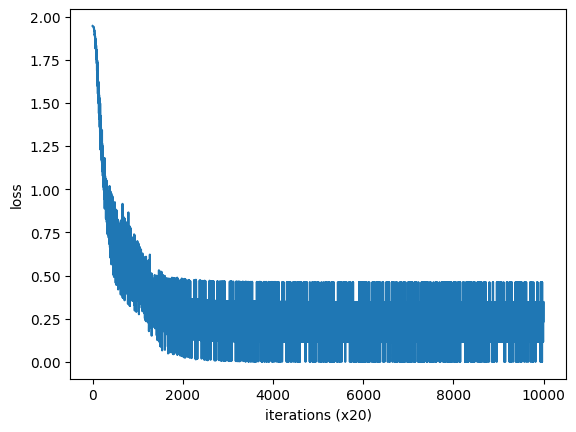

you: [-2.645307   -4.965999    0.47804752  0.7655908  -2.2443383 ]
say: [ 0.8097701  0.2799439 -1.4707173 -1.9755452  1.8485279]
goodbye: [-1.7288653  1.1638626  3.1599455  2.9346313 -2.9372497]
and: [ 3.0347161  3.3331416 -0.9433818 -1.7538372  1.5770755]
i: [-1.725073   1.1349725  3.1471524  2.9194498 -2.914358 ]
hello: [-2.6421711  -4.9371834   0.49140823  0.7788693  -2.259882  ]
.: [-3.38847   -2.5237942 -2.2585435 -2.0720134  2.1047966]


In [7]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 10000
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(f'{word}: {word_vecs[word_id]}')

## 3.5 word2vecに関する補足

### 3.5.1 CBOWモデルと確率

C_bowモデルの損失関数は負の対数尤度である．
$$
L = -\frac{1}{T} \sum_{t=1}^{T} \log P(w_t | w_{t-1}, w_{t+1})
$$
事後確率，$w_{t-1}$と$w_{t+1}$が与えられたときの$w_t$の確率を表す．

### 3.5.2 skip-gramモデル

コンテキスト間の単語に，慣例性がないと仮定する．

$$
L = -\frac{1}{T} \sum_{t=1}^{T} \log P( w_{t-1}, w_{t+1} | w_t) \\
= -\frac{1}{T} \sum_{t=1}^{T} \log P( w_{t-1} | w_t) - \frac{1}{T} \sum_{t=1}^{T} \log P( w_{t+1} | w_t)
$$

skipp-gramモデルは，一つの単語からその周囲の単語を予測する．これは難しい問題である．タフな問題であるからこそ，C-bowモデルよりも精度が高い．

### 3.5.3 カウントベース v.s. 推論ベース

語彙に新しい単語を追加するケース
- カウントベースの手法では，コーパス全体を再計算する必要がある
- 推論ベースの手法では，学習済みのモデルに新しい単語を追加するだけでよい．
単語の分散表現の性質
* カウントベースの手法では，単語の類似性がエンコードされる
* 単語の類似性に加えて，複雑な単語間のパターンも捉えられる

しかし，一般的に，推論ベースとカウントベースの手法には優劣がつけられないことが示されている．
* ハイパパラメータの依存がつよい



## 3.6 まとめ
推論ベースの手法は，推測することを目標として，その副産物として単語の分散表現を得られる．

word2vecは推論ベースの手法であり，シンプルな2種類のニューラルネットワークで構築されている．

